# Train different Neural Networks on a Traffic Sign Detection Dataset

In [1]:
import matplotlib.pyplot as plt
from copy import deepcopy
import os
from enum import Enum
from abc import ABC, abstractmethod
from typing import Optional
import random
import numpy as np
from PIL import Image

In [2]:
import yaml

class DataType(Enum):
    TRAIN = 1
    TEST = 2
    VALID = 3

class Label:
    def __init__(self, raw_data: str) -> None:
        split_data = raw_data.split(' ')
        self.category = int(split_data[0])
        self.center_x, self.center_y, self.width, self.height = map(float, split_data[1:])

class Entry:
    def __init__(self, image: np.array, labels: list[Label], image_name: str) -> None:
        self.image = image
        self.labels = labels
        self.image_name = image_name


dataset_path = 'data/traffic-signs-detection'
info_file = os.path.join(dataset_path, 'car/data.yaml')
categories = yaml.load(open(info_file), Loader=yaml.FullLoader)['names']

img_size = 128
min_bounding_box_size = 0.2
only_single_label = True
forbidden_file_prefixes = ['FisheyeCamera', 'road']
grayscale = False

def load_image_data(type: DataType):
    data_path = os.path.join(dataset_path, 'car', type.name.lower())
    images_path = os.path.join(data_path, 'images')
    labels_path = os.path.join(data_path, 'labels')

    entries = []
    files_in_folder = os.listdir(images_path)
    print(f'Scanning {len(files_in_folder)} entries from {images_path} and {labels_path}...')

    for image_name in files_in_folder:
        image = plt.imread(os.path.join(images_path, image_name))
        image = np.array(Image.fromarray(image).resize((img_size, img_size)))

        if grayscale:
            image = np.mean(image, axis=2)
        
        image = image / 255.0
        labels_raw = open(os.path.join(labels_path, image_name.replace('.jpg', '.txt'))).read().split('\n')
        labels = [Label(label) for label in labels_raw if label]

        if (
            only_single_label and len(labels) > 1
            or len(labels) == 0
            or any([image_name.startswith(prefix) for prefix in forbidden_file_prefixes])
            or any([label.width < min_bounding_box_size or label.height < min_bounding_box_size for label in labels])
        ):
            continue

        entries.append(Entry(image, labels, image_name))

    return entries

train_data = load_image_data(DataType.TRAIN)
validate_data = load_image_data(DataType.VALID)
test_data = load_image_data(DataType.TEST)

print(f'Loaded {len(train_data)} training images, {len(validate_data)} validation images and {len(test_data)} test images')

Scanning 3530 entries from data/traffic-signs-detection\car\train\images and data/traffic-signs-detection\car\train\labels...
Scanning 801 entries from data/traffic-signs-detection\car\valid\images and data/traffic-signs-detection\car\valid\labels...
Scanning 638 entries from data/traffic-signs-detection\car\test\images and data/traffic-signs-detection\car\test\labels...
Loaded 1939 training images, 493 validation images and 335 test images


Displaying 6 random images from each of the following categories: Green Light, Speed Limit 100, Speed Limit 90, Stop


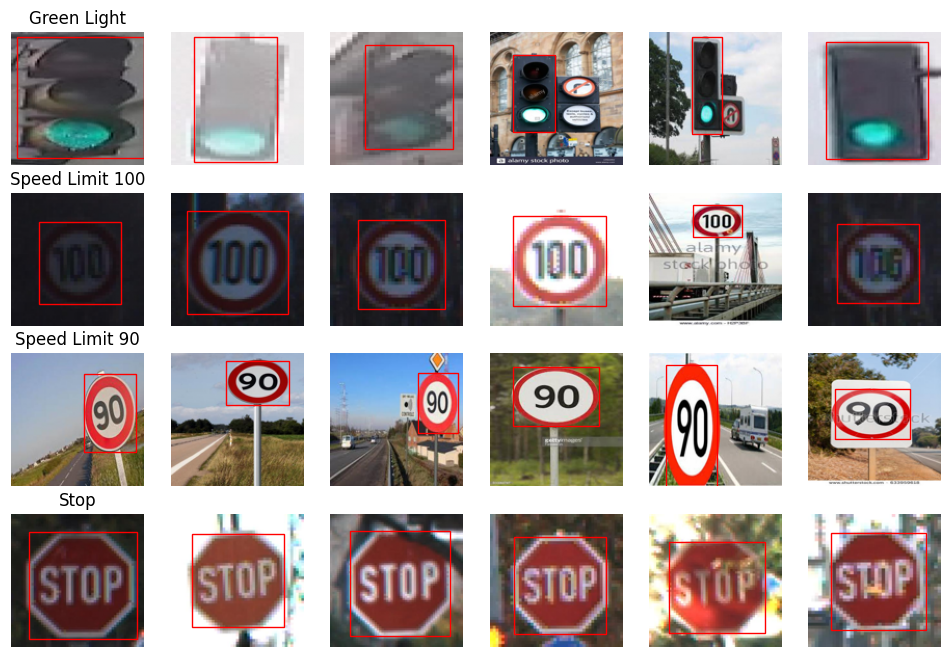

In [3]:
num_images = 6
categories_to_display = [0, 3, 13, 14]
fig, axs = plt.subplots(len(categories_to_display), num_images, figsize=(num_images * 2, len(categories_to_display) * 2))
print(f'Displaying {num_images} random images from each of the following categories: {', '.join([categories[category] for category in categories_to_display])}')

for idx, category in enumerate(categories_to_display):
    category_entries = [entry for entry in validate_data if entry.labels[0].category == category]
    
    if len(category_entries) >= num_images:
        selected_entries = random.sample(category_entries, num_images)
    else:
        selected_entries = category_entries
    
    for i, entry in enumerate(selected_entries):
        axs[idx, i].imshow(entry.image, cmap='gray')
        axs[idx, i].axis('off')
        if i == 0:
            axs[idx, i].set_title(categories[category])
            
        for label in entry.labels:
            x = label.center_x * img_size
            y = label.center_y * img_size
            w = label.width * img_size
            h = label.height * img_size
            rect = plt.Rectangle((x - w / 2, y - h / 2), w, h, fill=False, color='r')
            axs[idx, i].add_patch(rect)

for ax in axs.flat:
    ax.axis('off')

plt.show()


In [4]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras.optimizers import Adam

# create model
model = Sequential()
model.add(Input(shape=(img_size, img_size, 3)))
model.add(Conv2D(1, (8, 8), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train model
def get_data(data: list[Entry]):
    images = np.array([entry.image for entry in data])
    labels = np.array([entry.labels[0].category for entry in data])
    return images, labels

train_images, train_labels = get_data(train_data)
validate_images, validate_labels = get_data(validate_data)

model.fit(train_images, train_labels, epochs=10, validation_data=(validate_images, validate_labels))

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.1346 - loss: 2.6879 - val_accuracy: 0.1420 - val_loss: 2.4895
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.2597 - loss: 2.3280 - val_accuracy: 0.3813 - val_loss: 1.8761
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5574 - loss: 1.4274 - val_accuracy: 0.4868 - val_loss: 1.6570
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7831 - loss: 0.7945 - val_accuracy: 0.6065 - val_loss: 1.6845
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8920 - loss: 0.4403 - val_accuracy: 0.6004 - val_loss: 1.8554
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9260 - loss: 0.2877 - val_accuracy: 0.6045 - val_loss: 1.9852
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9463 - loss: 0.2427 - val_accuracy: 0.6268 - val_loss: 2.1672
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9846 - loss: 0.1169 - val_accuracy: 0.6227 - v

In [5]:
# evaluate model
test_images, test_labels = get_data(test_data)
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7319 - loss: 1.6343
Accuracy: 63.88%


Text(0.5, 1.0, 'Laplace-Filter')

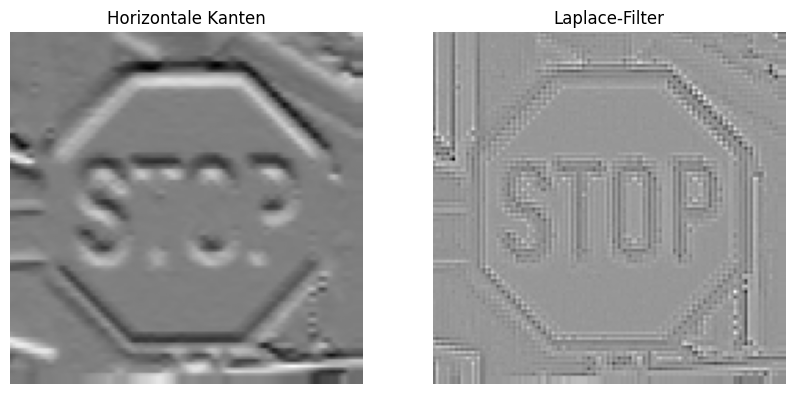

In [ ]:
def apply_filter(image: np.array, filter: np.array, stride: int = 1)->np.array:
    image_copy = deepcopy(image)
    filter_size = filter.shape[0]
    image_size = image.shape[0]
    for i in range(0, image_size - filter_size + 1, stride):
        for j in range(0, image_size - filter_size + 1, stride):
            image[i:i + filter_size, j:j + filter_size] = (image_copy[i:i + filter_size, j:j + filter_size] * filter).sum()
    
    return image


stop_signs = [entry for entry in validate_data if entry.labels[0].category == 14]
grayscale_img = np.array(stop_signs[9].image).sum(axis=2) / 3
vertical_edge_filter = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
horizontal_edge_filter = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
laplace_edge_filter = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

plt.axis('off')
plt.imshow(grayscale_img, cmap='gray')
# plt.imsave('Stoppschild_laplace.png', grayscale_img, cmap='gray')

# horizontal = apply_filter(deepcopy(grayscale_img),  horizontal_edge_filter, stride=1)
# laplace = apply_filter(deepcopy(grayscale_img), laplace_edge_filter, stride=1)
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow(horizontal, cmap='gray')
# axs[0].axis('off')
# axs[0].set_title('Horizontale Kanten')

# axs[1].imshow(laplace, cmap='gray')
# axs[1].axis('off')
# axs[1].set_title('Laplace-Filter')


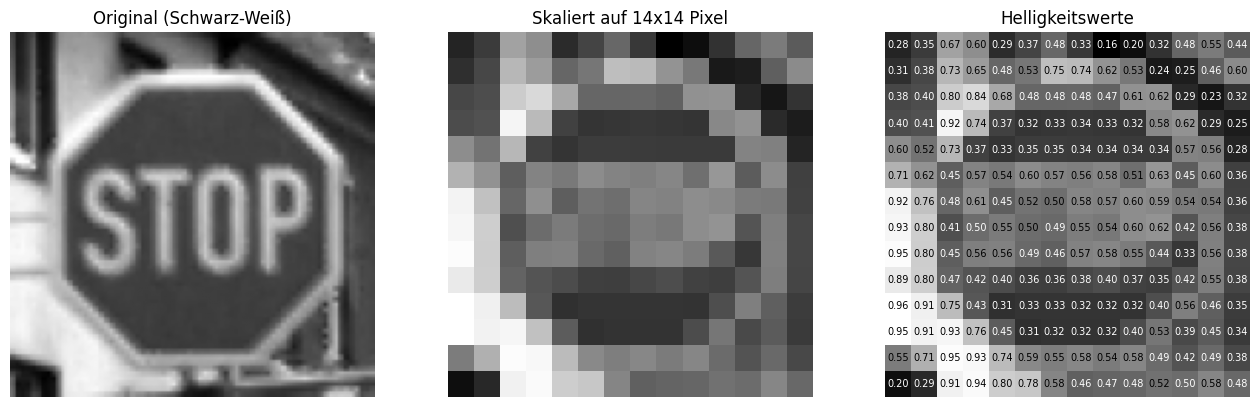

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Text(0.5, 1.0, 'Output of First Layer')

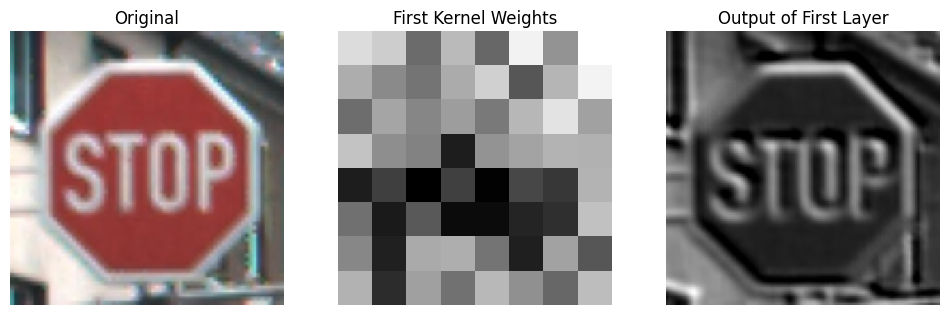

In [35]:
# get the output value of the first layer of the custom model
# print(model.layers)

layer_models = []
for i, layer in enumerate(model.layers):
    layer_model = Sequential()
    for j in range(i + 1):
        layer_model.add(model.layers[j])
    layer_models.append(layer_model)

# layer_models[1].summary()

# image = train_images[:1]
# print(image.shape)
# layer_models[1].predict(image)

# raise

# while True:
#     # keras expects a batch of images, so we need to add an additional dimension to the image
#     input_data = test_images[np.random.randint(0, len(test_images))][np.newaxis]
#     layer_output = [layer_model.predict(input_data) for layer_model in layer_models]

#     # the plot should look like this:
#     #                        Layer 1 Filter 1 weights     Layer 1 Output 1       ...       Layer n Filter 1 weights     Layer n Output 1      
#     # Original Image         ...                          ...                    ...       ...                          ...                     Predicted Category
#     #                        Layer 1 Filter n weights     Layer 1 Output n       ...       Layer n Filter n weights     Layer n Output n
#     #

#     fig, ax, plt.subplots()


#     plt.show()

stop_signs = [entry for entry in validate_data if entry.labels[0].category == 14]

# display the stop_signs[9].image in black and white and 28x28 pixels
# right beside it display the same image but instead of pixels show values between 0 and 1 for the pixels
size = 14
grayscale_img = np.array(stop_signs[9].image).sum(axis=2) / 3
scaled_img = np.array(Image.fromarray(grayscale_img).resize((size, size)))
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
axs[0].imshow(grayscale_img, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original (Schwarz-Weiß)')

axs[1].imshow(scaled_img, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Skaliert auf 14x14 Pixel')

axs[2].imshow(scaled_img, cmap='gray')
axs[2].axis('off')
axs[2].set_title('Helligkeitswerte')

for i in range(size):
    for j in range(size):
        axs[2].text(j, i, f'{scaled_img[i, j]:.2f}', ha='center', va='center', color='black' if scaled_img[i, j] > 0.5 else 'white', fontsize=7)

plt.show()


input_data = test_images[np.random.randint(0, len(test_images))][np.newaxis]
input_data = stop_signs[9].image[np.newaxis]
layer_output = layer_models[0].predict(input_data)
# plot the original image, the weights of the first kernel and the output of the first layer
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(input_data[0])
axs[0].axis('off')
axs[0].set_title('Original')

weights = model.layers[0].get_weights()[0]
weights_min = weights.min()
weights_max = weights.max()
weights = (weights - weights_min) / (weights_max - weights_min)
axs[1].imshow(weights[:, :, 0, 0], cmap='gray')
axs[1].axis('off')
axs[1].set_title('First Kernel Weights')

output = layer_output[0]
axs[2].imshow(output[:, :, 0], cmap='gray')
axs[2].axis('off')
axs[2].set_title('Output of First Layer')


## What happened?
1. I suffered from exploding gradients with HeInitialization() and MeanSquaredError(). I tried gradient clipping to 1.0 but turns out I don't have exploding gradients but vanishing gradients and exploding outputs. The outputs were very high with very low gradients, weird... Possible reasons are MeanSquaredError(), ReLU() and the batch size of 1 leading to instable gradients. Other potential reason: high learning rate.
2. I changed to CrossEntropy() -> still vanishing gradients
3. LeakyReLU() -> still vanishing
4. Used RandomInitialization() and Sigmoid() activation function, works perfectly now

I'm going to try adding batch processing so it will also work, maybe something with my Softmax output function was wrong, I want to try the original architecture (128 64 LeakyReLU, CrossEntropy, Xavier but with a different output activation function to see if the code for Softmax is broken)


